In [2]:
# clear all variables
for i in list(globals().keys()):
    if(i[0] != '_'):
        exec('del {}'.format(i))

#suppress future warnings -- not really a good idea 
from warnings import simplefilter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import f1_score
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed
%matplotlib inline

from pandas import DataFrame, Series
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, silhouette_score
import csv
import xlrd
import math
from IPython.display import set_matplotlib_formats
from matplotlib import figure
from IPython.display import FileLink, FileLinks
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

from imblearn.over_sampling import SMOTE


#### Create folders
def mkdir(dirName):
    
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")
        
print('done')     


done


# Data pre-processing

In [ ]:

mkdir('WorkingAnalysis')
mkdir('WorkingAnalysis/cluster1')
mkdir('WorkingAnalysis/cluster1/data')
mkdir('WorkingAnalysis/cluster1/ranking')
mkdir('WorkingAnalysis/cluster1/signatures')
mkdir('WorkingAnalysis/cluster1/coefficients')

''' Load and pre-process dataset '''
df=load_dataset('../data/selected_clinical_original_use.csv').dropna() \
                        .drop(columns=['lastint']) \
                        .replace({'No': 0, 'Mild': 1, 'Mod':2, 'Sev':3}) \
                        .replace({'Yes': 1}) \
                        .replace({'Women':0, 'Men':1}) \
                        .replace({'FP':0, 'FN':1, 'TP&TN':0}) \
                        .drop(columns=['membership'])
df['membership'] = df.pop('cluster').sample(frac=1.0)

print(df.membership.value_counts())

''' save a copy of  the data '''
df.to_csv('WorkingAnalysis/cluster1/data/cluster1_dset.csv',index=False)

''' MinMax scaling of the numeric features '''
numeric_cols=['age', 'interval', 'gapd', 'gap', 'brain_wgt']                 # numeric features
df[numeric_cols]=MinMaxScaler().fit_transform(df[numeric_cols])  # transform

''' save a copy of  the data with numeric features scaled '''
df.to_csv('WorkingAnalysis/cluster1/data/cluster1_dset_scaled.csv',index=False)

'''get cluster 1 dataset'''
df1=df

''' seperate into data and labels '''
X_all=df1.drop(columns=['membership', 'Case'])
y_all=df1.membership

''' Syntethic Minority Oversampling TEchnique (SMOTE) '''
df1_data, df1_label = SMOTE().fit_resample(X_all, y_all)

''' Split the X_all and y_all '''
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(df1_data, df1_label, 
                                                                    test_size = 0.30,
                                                                    random_state = 220)
''' check how many samples and features remain '''
X_all_train.shape


Directory  WorkingAnalysis  already exists
Directory  WorkingAnalysis/cluster1  already exists
Directory  WorkingAnalysis/cluster1/data  already exists
Directory  WorkingAnalysis/cluster1/ranking  already exists
Directory  WorkingAnalysis/cluster1/signatures  already exists
Directory  WorkingAnalysis/cluster1/coefficients  already exists
0    91
1    22
Name: membership, dtype: int64


(127, 31)

# Feature Selection: Removing with a large fraction of constant values

In [ ]:
from tools.cfas_processing import FeatureSelector

# Define steps
step1 = {'Constant Features': {'frac_constant_values': 0.9}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)
X_selected.shape

# This stage is optional and has not been included 


Removing Constant Features
['pickh', 'lewyh', 'spongh', 'lossf', 'losst', 'gliosf', 'gliost', 'superglf', 'superglt', 'pickf', 'pickt', 'balloonf', 'balloont', 'lewyf', 'lewyt', 'spongf', 'spongt', 'lewys']

Done selecting features


(127, 13)

# Feature Selection: Removing highly correlated features

In [ ]:
# Define steps
step1 = {'Correlated Features': {'correlation_threshold': 0.85}}

# Place steps in a list in the order you want them execute it
steps = [step1]

# Initialize FeatureSelector()
fs = FeatureSelector()

# Apply feature selection methods in the order they appear in steps

''' Commenting line to NOT INCLUDE removing of constant features '''
#fs.fit(X_selected, y_all_train, steps)  

''' Use ALL features without dropping features with highly constant data '''
fs.fit(X_all_train, y_all_train, steps)

# Get selected features
X_selected = fs.transform(X_all_train)

Removing Correlated Features
['gapd', 'gap']

Done selecting features


# Feature ranking to only select the most significant features   -- Use RandomForestClassifier to rank features

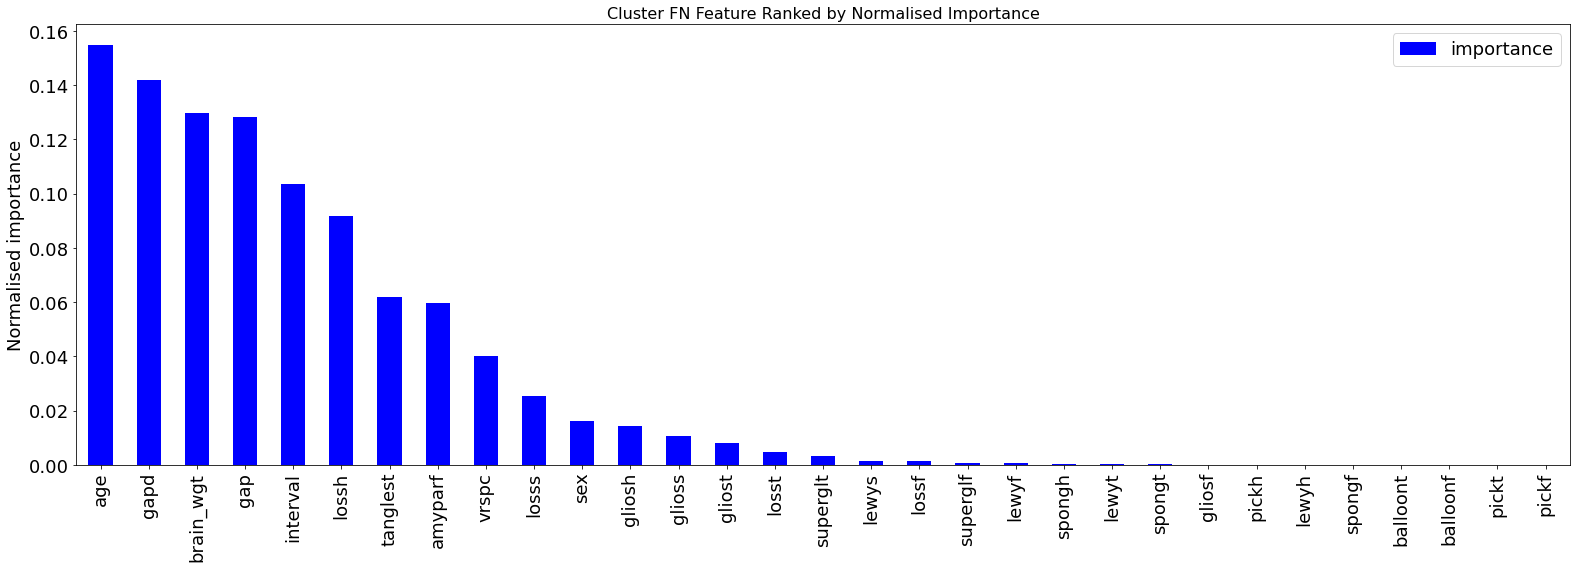

In [ ]:
# Define estimator
estimator = RandomForestClassifier(n_estimators = 100, max_depth = 7, min_samples_leaf = 2, min_samples_split = 2, random_state=220)
#estimator = RandomForestClassifier(random_state=220)

# Option 'X_selected' for dropping correlated and highly constant

#estimator.fit(X_selected, y_all_train)
estimator.fit(X_all_train, y_all_train)

# create a dataFrame of feature importance
#imp=pd.DataFrame({'feature':X_selected.columns,'importance':estimator.feature_importances_}).sort_values(by='importance',ascending=False)
imp=pd.DataFrame({'feature':X_all_train.columns,'importance':estimator.feature_importances_}).sort_values(by='importance',ascending=False)

# get significant features
cluster_1_significant_features = imp[imp.importance > 0.0]

imp.plot.bar(x='feature', y='importance', rot=0,figsize=(22,8), color='blue')
plt.xticks(rotation='vertical',fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('')
plt.ylabel('Normalised importance',fontsize=18)
plt.legend(fontsize=18)
plt.title('Cluster FN Feature Ranked by Normalised Importance',fontsize=16)
plt.tight_layout()

# save 
imp.to_csv('WorkingAnalysis/cluster1/ranking/cluster_1_feature_ranking.csv',index=False)
plt.savefig('WorkingAnalysis/cluster1/ranking/cluster_1_feature_ranking.png')
plt.savefig('WorkingAnalysis/cluster1/ranking/cluster_1_feature_ranking.pdf')


# Feature selection / ranking  -- based on Recursive Feature Elimination (RFE) ... RFECV

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn import metrics

accuracy_train=[]
accuracy_test=[]
f1_train=[]
f1_test=[]

roc_train=[]
roc_test=[]

num_repeat=50  # number of bootstrap samples
max_size = cluster_1_significant_features.shape[0]

# feature selection based on recursive feature elimination
for size in range(1,max_size+1):
    # get data
    for i in range(1,num_repeat+1):

        # get random 90% of samples
        #data=pd.concat([X_selected[cluster_1_significant_features.feature], y_all_train], axis=1).sample(frac=0.9, replace=False)
        data=pd.concat([X_all_train[cluster_1_significant_features.feature], y_all_train], axis=1).sample(frac=0.98, replace=False)
        
        X=data.drop(columns=['membership'])
        y=data.membership
        
        # model
        #estimator = SVR(kernel="linear")
        estimator = RandomForestClassifier(n_estimators = 100, max_depth = 7, min_samples_leaf = 2, min_samples_split = 2, random_state=220)

        #RFE
        selector = RFE(estimator, n_features_to_select=size, step=1)

        # fit RFE
        selector = selector.fit(X, y)
        
        # accumulate ranking
        if(i==1):
            exec("size_%d"%size+"_ranking = selector.ranking_")
        else:
            exec("size_%d"%size+"_ranking = size_%d"%size+"_ranking + selector.ranking_")
    
    # save signature
    exec("size_%d"%size+"_signature=pd.DataFrame({'feature':X.columns, 'rank':size_%d"%size+"_ranking/(num_repeat)}).sort_values(by='rank')")
    
    # save signatures
    exec("signature_0_size_%d"%size+" = size_%d"%size+"_signature[:%d"%size+"]")     
    exec("signature_0_size_%d"%size+".to_csv('WorkingAnalysis/cluster1/signatures/signature_1_size_%d"%size+".csv',index=False)")
    
    # create and fit model
    model = RandomForestClassifier(n_estimators = 100, max_depth = 7, min_samples_leaf = 2, min_samples_split = 2, random_state=220)
    exec("signature_1_size_%d"%size+" = size_%d"%size+"_signature[:%d"%size+"].feature") 
    exec("model.fit(X_all_train[signature_1_size_%d"%size+"], y_all_train)")
    
    # Make predictions
    exec("y_pred_train = model.predict(X_all_train[signature_1_size_%d"%size+"])") 
    exec("y_pred_test = model.predict(X_all_test[signature_1_size_%d"%size+"])") 
    
    # Measure performance
    train_acc=( metrics.accuracy_score(y_all_train, y_pred_train))
    test_acc=(metrics.accuracy_score(y_all_test, y_pred_test))

    train_f1=(f1_score(y_all_train, y_pred_train, average='weighted'))
    test_f1=(f1_score(y_all_test, y_pred_test, average='weighted'))

    # save performances
    accuracy_train.append(train_acc)
    accuracy_test.append(test_acc)
    
    f1_train.append(train_f1)
    f1_test.append(test_f1)
    
    exec("train_roc=roc_auc_score(y_all_train, model.predict_proba(X_all_train[signature_1_size_%d"%size+"])[:, 1])") 
    exec("test_roc=roc_auc_score(y_all_test, model.predict_proba(X_all_test[signature_1_size_%d"%size+"])[:, 1])") 
    
    roc_train.append(train_roc)
    roc_test.append(test_roc)
    
    # get coefficients
    estimator = SVR(kernel="linear")
    exec("estimator.fit(X[signature_1_size_%d"%size+"],y)")
    exec("signature_1_size_%d"%size+"_coefficients=pd.DataFrame({'feature':signature_1_size_%d"%size+", 'coeff':np.ravel(estimator.coef_)})")
    exec("signature_1_size_%d"%size+"_coefficients")
    
    # save
    exec("signature_1_size_%d"%size+"_coefficients.to_csv('WorkingAnalysis/cluster1/coefficients/signature_1_size_%d"%size+"_coefficients.csv',index=False)")
    
    # DEBUG: show progress
    print(size,'/',max_size)

# get candidate signatures performances
signatures_1_performances = pd.DataFrame({'size':range(1,max_size+1), 'test_acc':accuracy_test, 'test_f1':f1_test, 'test_roc':roc_test})

# plot performances
plt.figure(figsize=(12,6))
plt.plot(signatures_1_performances['size'], signatures_1_performances.test_roc,'o-')
plt.xlim(0,max_size)
plt.ylim(0.3,1.0)
plt.xlabel('Size',fontsize=18)
plt.ylabel('AuC',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Cluster TP&TN candidate signatures classification performance',fontsize=16)
plt.tight_layout()

# save figure
plt.savefig('WorkingAnalysis/cluster1/signatures/signatures_1_performances.png')
plt.savefig('WorkingAnalysis/cluster1/signatures/signatures_1_performances.pdf')
#signatures_1_performances   


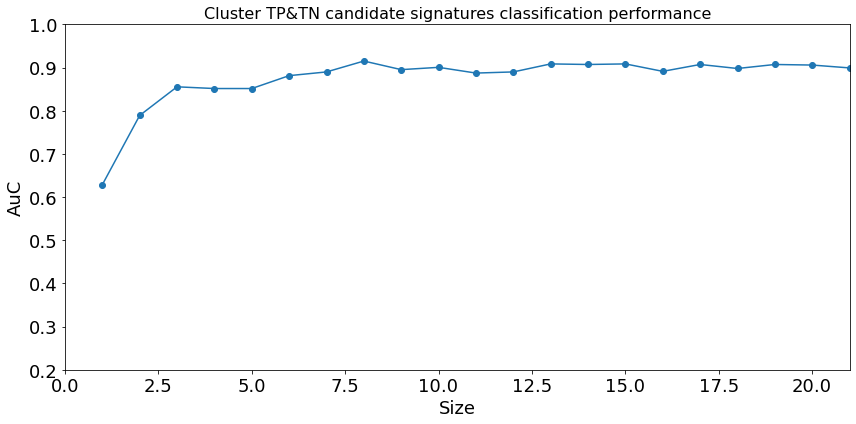

In [ ]:
# get candidate signatures performances
signatures_1_performances = pd.DataFrame({'size':range(1,max_size+1), 'test_acc':accuracy_test, 'test_f1':f1_test, 'test_roc':roc_test})

# plot performances
plt.figure(figsize=(12,6))
plt.plot(signatures_1_performances['size'], signatures_1_performances.test_roc,'o-')
plt.xlim(0,max_size)
plt.ylim(0.2,1.0)
plt.xlabel('Size',fontsize=18)
plt.ylabel('AuC',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Cluster TP&TN candidate signatures classification performance',fontsize=16)
plt.tight_layout()

# save figure
plt.savefig('WorkingAnalysis/cluster1/signatures/signatures_1_performances.png')
plt.savefig('WorkingAnalysis/cluster1/signatures/signatures_1_performances.pdf')
#signatures_1_performances   

# Regression plot

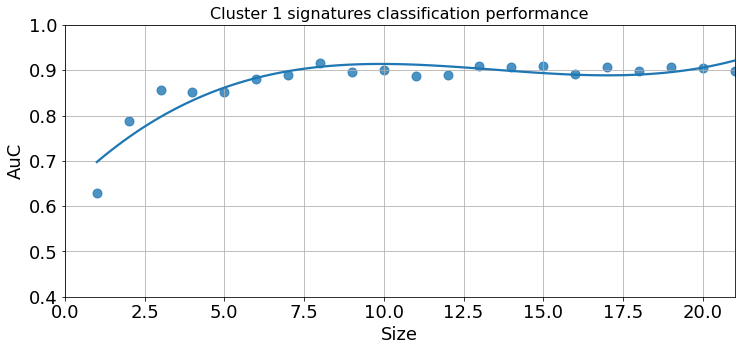

In [ ]:

plt.figure(figsize=(12,5))
sns.regplot(x=signatures_1_performances['size'], y=signatures_1_performances.test_roc, order=3, scatter_kws={"s": 80},  ci=None)
plt.xlim(0,max_size)
plt.ylim(0.4,1.)
plt.xlabel('Size',fontsize=18)
plt.ylabel('AuC',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Cluster 1 signatures classification performance',fontsize=16)
#plt.tight_layout()
plt.grid()

# save figure
plt.savefig('WorkingAnalysis/cluster1/signatures/signatures_1_performances_regplot.png')
plt.savefig('WorkingAnalysis/cluster1/signatures/signatures_1_performances_regplot.pdf')
#signatures_0_performances   


# Plot coefficient for Cluster 0 -- 'True Positives & True Negatives'

maybe best is 7
signature_0_size_7

In [ ]:
signature_1_size_10_coefficients